(384, 512, 3)


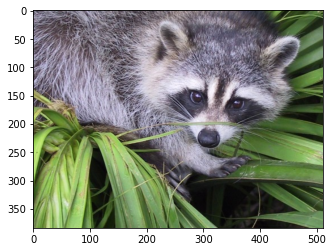

In [35]:
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import math
import pdb;

img = Image.open('racoon.jpg')
# plt.imshow(img)
print(np.shape(img))
plt.show()
racoon = imread('racoon.jpg')
# plt.imshow(racoon)
newrac = racoon/255
plt.imshow(newrac)

In [2]:
#downscale image
#Pad image
#get neighborhood for each pixel
#match up said neighborhood with original image corresponding pixel
#triplicate each neighborhood 3 times so to match with each color of each pixel
#put each neighborhood/pixel pair into a matrix
#set up matrix in the proper way for least squares regression
#run the calculations

In [46]:
def calcRegression(images):
    neighborhoods = []

    images0r = []
    images0g = []
    images0b = []
    images1r = []
    images1g = []
    images1b = []
    images2r = []
    images2g = []
    images2b = []
    images3r = []
    images3g = []
    images3b = []
    
    for image in images:
        #convert image to 0-1 values as imread opens them as values 0-255
        image = image/255
        downscaled = downscaleByHalf(image)
        if not neighborhoods:
            neighborhoods = getNeighborhoods(downscaled,5)
        else:
            np.concatenate((neighborhoods,getNeighborhoods(downscaled,5)))
        im0,im1,im2,im3 = breakupImage(image)
        images0r.append(im0[:,:,0])
        images0g.append(im0[:,:,1])
        images0b.append(im0[:,:,2])
        images1r.append(im1[:,:,0])
        images1g.append(im1[:,:,1])
        images1b.append(im1[:,:,2])
        images2r.append(im2[:,:,0])
        images2g.append(im2[:,:,1])
        images2b.append(im2[:,:,2])
        images3r.append(im3[:,:,0])
        images3g.append(im3[:,:,1])
        images3b.append(im3[:,:,2])

    neighborhoods = np.insert(neighborhoods,0,1,axis =1)
        
    # b vectors (original size images) reshaped to be vectors
    r0 = np.vstack(np.reshape(images0r,-1))
    g0 = np.vstack(np.reshape(images0g,-1))
    b0 = np.vstack(np.reshape(images0b,-1))
    r1 = np.vstack(np.reshape(images1r,-1))
    g1 = np.vstack(np.reshape(images1g,-1))
    b1 = np.vstack(np.reshape(images1b,-1))
    r2 = np.vstack(np.reshape(images2r,-1))
    g2 = np.vstack(np.reshape(images2g,-1))
    b2 = np.vstack(np.reshape(images2b,-1))
    r3 = np.vstack(np.reshape(images3r,-1))
    g3 = np.vstack(np.reshape(images3g,-1))
    b3 = np.vstack(np.reshape(images3b,-1))


    #regressions
    result0r = np.linalg.lstsq(neighborhoods, r0, rcond=None)[0]
    result0g = np.linalg.lstsq(neighborhoods, g0, rcond=None)[0]
    result0b = np.linalg.lstsq(neighborhoods, b0, rcond=None)[0]
    result1r = np.linalg.lstsq(neighborhoods, r1, rcond=None)[0]
    result1g = np.linalg.lstsq(neighborhoods, g1, rcond=None)[0]
    result1b = np.linalg.lstsq(neighborhoods, b1, rcond=None)[0]
    result2r = np.linalg.lstsq(neighborhoods, r2, rcond=None)[0]
    result2g = np.linalg.lstsq(neighborhoods, g2, rcond=None)[0]
    result2b = np.linalg.lstsq(neighborhoods, b2, rcond=None)[0]
    result3r = np.linalg.lstsq(neighborhoods, r3, rcond=None)[0]
    result3g = np.linalg.lstsq(neighborhoods, g3, rcond=None)[0]
    result3b = np.linalg.lstsq(neighborhoods, b3, rcond=None)[0]
    
    results = [result0r, result0g, result0b, result1r, result1g, result1b, result2r, result2g, result2b, result3r, result3g, result3b]
    
    return results 
        


In [64]:
def upscaleImg(img, regressions):
    neighborhoods = getNeighborhoods(img, 5)
    neighborhoods = np.insert(neighborhoods,0,1,axis =1)

    pixelColorValues = []
    for i in range (0,12):
        values = neighborhoods @ regressions[i]
        values = np.reshape(values,(x,y,1))
        pixelColorValues.append(values)
#     r0 = neighborhoods @ regressions[0]
#     g0 = neighborhoods @ regressions[1]
#     b0 = neighborhoods @ regressions[2]
#     r1 = neighborhoods @ regressions[3]
#     g1 = neighborhoods @ regressions[4]
#     b1 = neighborhoods @ regressions[5]
#     r2 = neighborhoods @ regressions[6]
#     g2 = neighborhoods @ regressions[7]
#     b2 = neighborhoods @ regressions[8]
#     r3 = neighborhoods @ regressions[9]
#     g3 = neighborhoods @ regressions[10]
#     b3 = neighborhoods @ regressions[11]
    
    for i in range (0, x*2):
        for j in range (0, y*2):
            
    
    
    return [r0,g0,b0,r1,g1,b1,r2,g2,b2,r3,g3,b3]

In [48]:
def downscaleByHalf(img, antiAliasing=False):
    toReturn = rescale(img, (0.5, 0.5, 1), anti_aliasing=antiAliasing)
    return toReturn

In [49]:
def padEdge(img,amount):
    padded = np.pad(img,((amount,amount),(amount,amount),(0,0)),mode='edge')
    return padded

In [50]:
def getNeighborhoods(image, neighborhoodWidth):
    neighborhoods = []
    neighborhoodWidth = abs(neighborhoodWidth)
    if (neighborhoodWidth%2 == 0):
        neighborhoodWidth = neighborhoodWidth - 1
    offset = math.floor(neighborhoodWidth/2)
    paddedImage = padEdge(image,offset)
    #for each pixel
    for row in range(offset,paddedImage.shape[0]-offset):
        for column in range(offset, paddedImage.shape[1]-offset):
            pixelToAdd = []
            #neighborhood loops
            for i in range(-offset,offset+1):
                for j in range(-offset,offset+1):
                    for k in range(0,3): #color
                        pixelToAdd.append(paddedImage[row+i,column+j,k])
            neighborhoods.append(pixelToAdd)
    return neighborhoods

In [51]:
def breakupImage(img):
    im1 = img[0::2,0::2,:] #start 1st row, 1st column
    im2 = img[0::2,1::2,:] #start 1st row, 2nd column
    im3 = img[1::2,0::2,:] #start 2nd row, 1st column
    im4 = img[1::2,1::2,:] #start 2nd row, 2nd column
    return im1,im2,im3,im4

In [52]:
images = []
images.append(racoon)
resRegression = calcRegression(images)


In [65]:
img = upscaleImg(racoon/255, resRegression)


x 384 y 512 z 3


In [62]:
print(np.shape(img[0]))
reshaped = np.reshape(img[0], (384,512))

(196608, 1)


In [9]:
newNeighborhoods = getNeighborhoods(racoon,5)

In [10]:
toUse = []
toUse.append(newNeighborhoods[0])
toUse.append(newNeighborhoods[1])

In [23]:
a = np.ndarray(0,1,2)
print(a < 2)
print(a>2)
if np.any(a > 1):
    print("hello")

TypeError: Cannot interpret '1' as a data type

[ 0.01622017  0.01495076  0.01763062  0.01622017  0.01495076  0.01763062
 -0.00248224 -0.00375164 -0.00107179  0.01608762  0.01481822  0.01749807
  0.02081542  0.01954601  0.02222587  0.01622017  0.01495076  0.01763062
  0.01622017  0.01495076  0.01763062 -0.00248224 -0.00375164 -0.00107179
  0.01608762  0.01481822  0.01749807  0.02081542  0.01954601  0.02222587
  0.01622017  0.01495076  0.01763062  0.01622017  0.01495076  0.01763062
 -0.00248224 -0.00375164 -0.00107179  0.01608762  0.01481822  0.01749807
  0.02081542  0.01954601  0.02222587  0.01184778  0.01086046  0.01339927
  0.01184778  0.01086046  0.01339927 -0.0099717  -0.01095901 -0.0084202
  0.01117363  0.01018631  0.01272512  0.02241765  0.02143033  0.02396914
  0.01678435  0.01636121  0.01875898  0.01678435  0.01636121  0.01875898
  0.00867997  0.00825684  0.0106546   0.00739649  0.00697336  0.00937112
  0.02240357  0.02198043  0.0243782 ]


[[0.45392157 0.42254902 0.49509804]
 [0.54313725 0.51176471 0.58431373]
 [0.50098039 0.47941176 0.54019608]
 [0.45098039 0.42647059 0.48823529]
 [0.37745098 0.35       0.40686275]
 [0.33333333 0.29313725 0.35490196]
 [0.33333333 0.28137255 0.34117647]
 [0.34705882 0.28921569 0.35294118]
 [0.35294118 0.3        0.38431373]
 [0.46666667 0.42254902 0.5       ]
 [0.53039216 0.49705882 0.57058824]
 [0.55686275 0.52941176 0.59215686]
 [0.4754902  0.45980392 0.52647059]
 [0.64117647 0.62941176 0.69607843]
 [0.55098039 0.54509804 0.61666667]
 [0.42647059 0.4254902  0.50294118]
 [0.42058824 0.41666667 0.4872549 ]
 [0.51078431 0.49215686 0.56764706]
 [0.45784314 0.43039216 0.50098039]
 [0.41764706 0.40588235 0.4627451 ]
 [0.32352941 0.32745098 0.3745098 ]
 [0.32058824 0.3245098  0.37156863]
 [0.42254902 0.40098039 0.44803922]
 [0.40784314 0.34705882 0.40294118]
 [0.44019608 0.35490196 0.40784314]
 [0.45294118 0.3745098  0.42254902]
 [0.55098039 0.4872549  0.53039216]
 [0.48921569 0.4372549  0.47

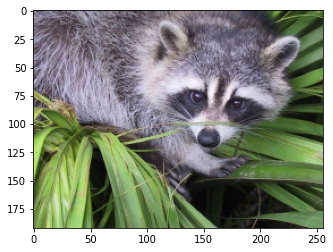

In [66]:
for i in range (0,12):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
#testingCode

In [40]:
a = [[[0, 1, 0],
  [1, 2, 0],
  [1, 3, 0],
  [1, 4, 0],
  [1, 5, 0]],

 [[2, 1, 0],
  [2, 2, 0],
  [2, 3, 0],
  [2, 4, 0],
  [2, 5, 0]],

 [[3, 1, 0],
  [3, 2, 0],
  [102, 103, 104],
  [3, 4, 0],
  [3, 5, 0]],

 [[4, 1, 0],
  [4, 2, 0],
  [4, 3, 0],
  [4, 4, 0],
  [4, 5, 0]],

 [[5, 1, 0],
  [5, 2, 0],
  [5, 3, 0],
  [5, 4, 0],
  [5, 5, 0]]]

# imagestest = []
# rchannel = racoon[:,:,0]
# gchannel = racoon[:,:,1]
# imagestest.append(rchannel)
# imagestest.append(gchannel)
# imagestest = np.reshape(imagestest,-1)

# print(imagestest)

# letters = [[["a","b","c"]]]

neighborhoods = getNeighborhoods(racoon,5)
neighborhoods2 = getNeighborhoods(racoon,5)
# print(neighborhoods)
# n2 = np.repeat(neighborhoods,3, 0)
print('hello')
# print(n2)
print(len(neighborhoods))
print(np.shape(neighborhoods))

# b= np.reshape(a,-1)
# np.vstack(b)
# b = np.vstack(a)
# print("hello b", b)
# print(b.shape)
# c = np.reshape(b,-1)
# d = np.vstack(c)
# print(d)
# print(d.shape)

hello
196608
(196608, 75)


In [51]:
both = np.concatenate((neighborhoods, neighborhoods2))
print(np.shape(both))

img2 = []
img2.append(np.reshape(racoon[:,:,0],-1))
print(np.shape(img2))
img2.append(np.reshape(racoon[:,:,1],-1))
print(np.shape(img2))

(393216, 75)
(1, 196608)
(2, 196608)


In [146]:
a = [[1,2,3],[0,1,4],[5,6,0]]
b = [10,11,12]

inv = np.linalg.inv(a)

act = inv @ b
res = np.linalg.lstsq(a,b,rcond = None)[0]
print(act)
print(res)

[ 18. -13.   6.]
[ 18. -13.   6.]
